### Download weights from drive before running this notebook

In [17]:
import tensorflow as tf
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
import json
import pickle

from utils.utils_stylegan2 import convert_images_to_uint8

from stylegan2_generator import StyleGan2Generator
impl = 'cuda' # 'ref' if cuda is not available in your machine
gpu = True # False if tensorflow cpu is used

weights_name = 'ffhq' # face model trained by Nvidia
generator = StyleGan2Generator(weights=weights_name, impl=impl, gpu=gpu)
w_average = np.load('weights/{}_dlatent_avg.npy'.format(weights_name))


Loaded ffhq generator weights!


In [355]:
latent_samples = np.random.RandomState(123).randn(10000, 512).astype('float32')
dlatent_samples = generator.mapping_network(latent_samples)
dlatent_avg = np.mean(dlatent_samples, axis=0, keepdims=True) # [1, 18, 512]
dlatent_std = (np.sum((dlatent_samples - dlatent_avg) ** 2) / 10000) ** 0.5

In [440]:
np.save('/cont/dlatent_avg.npy', dlatent_avg)
np.save('/cont/dlatent_std.npy', dlatent_std)

In [357]:
np.linalg.norm(dlatent_std)

42.4506089473402

In [260]:
def generate_and_plot_images(gen, seed, w_avg, truncation_psi=1):
    """ plot images from generator output """
    
    fig, ax = plt.subplots(1,3,figsize=(15,15))
    for i in range(3):
    
        # creating random latent vector
        rnd = np.random.RandomState(seed)
        z = rnd.randn(1, 512).astype('float32')

        # running mapping network
        dlatents = gen.mapping_network(z)
        # adjusting dlatents depending on truncation psi, if truncatio_psi = 1, no adjust
        dlatents = w_avg + (dlatents - w_avg) * truncation_psi 
        # running synthesis network
        out = gen.synthesis_network(dlatents)

        #converting image/s to uint8
        img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)

        #plotting images
        ax[i].axis('off')
        img_plot = ax[i].imshow(img.numpy()[0])
        
        seed += 1

def generate_image(dlatent):
    global generator
    out = generator.synthesis_network(dlatent.reshape((1, 18, 512))
    return convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True).numpy()[0]
        
def ten_image(gen, seed, w_avg, truncation_psi=1):
    rnd = np.random.RandomState(seed)
    z = rnd.randn(10, 512).astype('float32')
    dlatents = gen.mapping_network(z)
    out = gen.synthesis_network(dlatents)
    img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
    fig, ax = plt.subplots(5, 2, figsize=(15, 15))
    for i in range(5):
        for j in range(2):
            ax[i][j].axis('off')
            img_plot = ax[i][j].imshow(img.numpy()[i * 2 + j])
            
def one_image(gen, seed, truncation_psi=1):
    rnd = np.random.RandomState(seed)
    z = rnd.randn(1, 512).astype('float32')
    dlatents = gen.mapping_network(z)
    out = gen.synthesis_network(dlatents)
    img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
    PIL.Image.fromarray(img.numpy()[0], 'RGB').save('seed%04d.png' % seed)
    
    
def batch_image(batches, gen, start_seed):
    rnds = []
    for batch in range(batches):
        rnds.append(np.random.RandomState(start_seed + batch).randn(1, 512).astype('float32'))
    z = np.concatenate(rnds)
    dlatents = gen.mapping_network(z)
    out = gen.synthesis_network(dlatents)
    img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
    for batch in range(batches):
        PIL.Image.fromarray(img.numpy()[batch], 'RGB').save('seed%04d.png' % (start_seed + batch))



SyntaxError: invalid syntax (<ipython-input-260-3005963f6185>, line 30)

In [495]:

get_emotiondata(2)

{'person_id': 0,
 'demographics': {'age_group': 'Young Adult', 'gender': 'Male'},
 'appearance': {'glasses': 'Yes'},
 'emotions': {'anger': 0,
  'disgust': 0,
  'fear': 60,
  'joy': 0,
  'sadness': 0,
  'surprise': 0},
 'tracking': {'glances': 2, 'dwell': 0, 'attention': 1, 'blinking': 'No'},
 'pose': {'yaw': -6.1102934328754,
  'pitch': 14.25267770276,
  'roll': 0.21335587826817},
 'face': {'x': 50, 'y': 53, 'width': 870, 'height': 971},
 'distance': 290.02758789062,
 'landmarks': [{'leftEyeBrowOuterLeft': {'x': 313, 'y': 400}},
  {'leftEyeBrowInnerLeft': {'x': 369, 'y': 386}},
  {'leftEyeBrowInnerRight': {'x': 420, 'y': 389}},
  {'leftEyeBrowOuterRight': {'x': 476, 'y': 405}},
  {'righteEyeBrowOuterLeft': {'x': 574, 'y': 396}},
  {'rightEyeBrowInnerLeft': {'x': 628, 'y': 376}},
  {'rightEyeBrowInnerRight': {'x': 679, 'y': 371}},
  {'rightEyeBrowOuterRight': {'x': 727, 'y': 384}},
  {'noseBetweenEyes': {'x': 522, 'y': 481}},
  {'noseBridge': {'x': 522, 'y': 535}},
  {'noseBody': {'x':

In [369]:
%%time

def get_dlatents(seed):
    global generator
    latent = np.random.RandomState(seed).randn(1, 512).astype('float32')
    dlatent = generator.mapping_network(latent)
    return dlatent.numpy() # [1, 18, 512]

def normalize(vec): # [1, 18, 512]
    global dlatent_avg
    global dlatent_std
    return (vec - dlatent_avg) / dlatent_std

def get_facedata(seed):
    with open('/cont/face_responses/{:04}.json'.format(seed)) as f:
        data = json.load(f)
        if 'images' not in data:
            return None
        return data['images'][0]['faces'][0]
    
def get_emotiondata(seed):
    with open('/cont/emotion_responses/media{:04}.json'.format(seed)) as f:
        data = json.load(f)
        if 'frames' not in data:
            return None
        return data['frames'][0]['people'][0]
    
tmpX = []
labels = []
for seed in range(4096):
    if seed % 100 == 0:
        print(seed)
    try:
        data = get_facedata(seed)
        extended = get_emotiondata(seed)
        if not extended:
            continue
        data['extended'] = extended
    except:
        continue
    if not data:
        continue
    tmpX.append(normalize(get_dlatents(seed)))
    labels.append(data)

# tmpX is [N, 1, 18, 512]
X_data = np.array(tmpX)
# X_data is [N, 1, 18, 512]
X_data = np.array(tmpX).reshape((-1, 18*512))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
CPU times: user 56.2 s, sys: 28.2 s, total: 1min 24s
Wall time: 1min 39s


In [366]:
np.array(tmpX).shape[0]

3589

In [379]:
zero = np.zeros(shape=(18,512),dtype='float32')
avgzero = dlatent_avg.reshape((18, 512))

In [460]:
labels[0]

{'attributes': {'age': 29,
  'asian': 0.00037,
  'black': 9e-05,
  'gender': {'femaleConfidence': 1, 'maleConfidence': 0, 'type': 'F'},
  'glasses': 'None',
  'hispanic': 0.00032,
  'lips': 'Together',
  'other': 1e-05,
  'white': 0.99921},
 'chinTipX': 548,
 'chinTipY': 944,
 'confidence': 0.99944,
 'eyeDistance': 250,
 'face_id': 1,
 'height': 726,
 'leftEyeCenterX': 387,
 'leftEyeCenterY': 491,
 'pitch': 6,
 'quality': 0.13942,
 'rightEyeCenterX': 637,
 'rightEyeCenterY': 497,
 'roll': 2,
 'topLeftX': 175,
 'topLeftY': 204,
 'width': 575,
 'yaw': -19,
 'extended': {'person_id': 0,
  'demographics': {'age_group': 'Young Adult', 'gender': 'Female'},
  'appearance': {'glasses': 'No'},
  'emotions': {'anger': 0,
   'disgust': 0,
   'fear': 0,
   'joy': 0,
   'sadness': 0,
   'surprise': 0},
  'tracking': {'glances': 2, 'dwell': 0, 'attention': 1, 'blinking': 'No'},
  'pose': {'yaw': -20.195300752471,
   'pitch': -4.4897346317628,
   'roll': 0.90216917183929},
  'face': {'x': 26, 'y': 39

In [496]:
{x['extended']['demographics']['age_group'] for x in labels}

{'Adult', 'Child', 'Senior', 'Young Adult'}

(array([3.000e+00, 1.000e+00, 2.000e+00, 2.000e+00, 3.000e+00, 3.000e+00,
        2.200e+01, 6.400e+01, 2.514e+03, 8.250e+02, 1.110e+02, 1.500e+01,
        1.100e+01, 3.000e+00, 5.000e+00, 1.000e+00, 0.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00]),
 array([-22. , -19.5, -17. , -14.5, -12. ,  -9.5,  -7. ,  -4.5,  -2. ,
          0.5,   3. ,   5.5,   8. ,  10.5,  13. ,  15.5,  18. ,  20.5,
         23. ,  25.5,  28. ]),
 <a list of 20 Patch objects>)

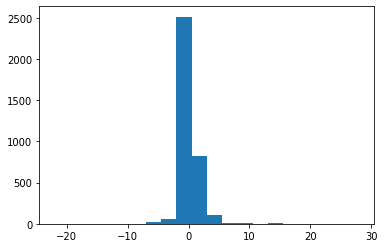

In [564]:
plt.hist([x['roll'] for x in labels], bins=20)

In [565]:
X_data = np.array(tmpX).reshape((-1, 18*512))
y_gender_data = np.array([x['attributes']['gender']['type'] == 'F' for x in labels])
y_black_data = np.array([x['attributes']['black'] > 0.5 for x in labels])
y_asian_data = np.array([x['attributes']['asian'] > 0.5 for x in labels])
y_hispanic_data =  np.array([x['attributes']['hispanic'] > 0.5 for x in labels])
y_white_data = np.array([x['attributes']['white'] > 0.5 for x in labels])
y_yaw_data = np.array([x['yaw'] > 0 for x in labels])
y_glasses_data = np.array([x['extended']['appearance']['glasses'] == 'Yes' for x in labels])
y_joy_data = np.array([x['extended']['emotions']['joy'] > 10.0 for x in labels])
y_anger_data = np.array([x['extended']['emotions']['anger'] > 1 for x in labels])
y_quality_data = np.array([x['quality'] > 0 for x in labels])
y_age_data = np.array([x['attributes']['age'] > 40 for x in labels])
y_blinking_data = np.array([x['extended']['tracking']['blinking'] == 'Yes' for x in labels])


In [4]:
from sklearn.linear_model import LogisticRegression, SGDClassifier, LinearRegression, Ridge
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
import sklearn

In [371]:
%%time

svm = sklearn.svm.LinearSVC(dual=False, max_iter=5000)
svm.fit(X_data, y_gender_data)
gender_coef = svm.coef_.reshape((18, 512))

CPU times: user 7.65 s, sys: 0 ns, total: 7.65 s
Wall time: 7.65 s


In [372]:
%%time

svm = sklearn.svm.LinearSVC(dual=False, max_iter=5000)
svm.fit(X_data, y_black_data)
black_coef = svm.coef_.reshape((18, 512))

CPU times: user 4.19 s, sys: 0 ns, total: 4.19 s
Wall time: 4.22 s


In [373]:
%%time

svm = sklearn.svm.LinearSVC(dual=False, max_iter=5000)
svm.fit(X_data, y_white_data)
white_coef = svm.coef_.reshape((18, 512))

CPU times: user 9.28 s, sys: 0 ns, total: 9.28 s
Wall time: 9.29 s


In [374]:
%%time

reg = sklearn.linear_model.LinearRegression()
Y = np.array([x['yaw'] for x in labels])
reg.fit(X_data, Y)
print("R^2: {}".format(reg.score(X_data, Y)))
# gender_lin_coef = reg.coef_.reshape((1, 18, 512))

R^2: 0.8469954177143335
CPU times: user 1min 32s, sys: 32.9 s, total: 2min 5s
Wall time: 31.9 s


In [450]:
yaw_lin_coef = reg.coef_.reshape((1, 18, 512))

In [125]:
black_lin_coef = reg.coef_.reshape((1, 18, 512))

(array([  8.,  26.,  65.,  93., 188., 251., 236., 347., 485., 491., 434.,
        383., 315., 214., 211., 166.,  94.,  56.,  15.,   4.]),
 array([-45. , -40.3, -35.6, -30.9, -26.2, -21.5, -16.8, -12.1,  -7.4,
         -2.7,   2. ,   6.7,  11.4,  16.1,  20.8,  25.5,  30.2,  34.9,
         39.6,  44.3,  49. ]),
 <a list of 20 Patch objects>)

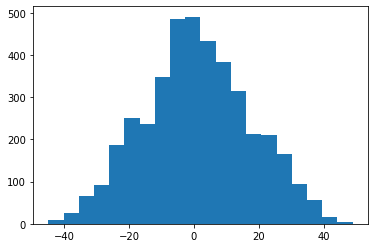

In [163]:
plt.hist( np.array([x['yaw'] for x in labels]), bins=20)

In [375]:
%%time

svm = sklearn.svm.LinearSVC(dual=False, max_iter=5000)
svm.fit(X_data, y_asian_data)
asian_coef = svm.coef_.reshape((18, 512))

CPU times: user 8.92 s, sys: 82.5 ms, total: 9 s
Wall time: 8.79 s


In [376]:
%%time

svm = sklearn.svm.LinearSVC(dual=False, max_iter=5000)
svm.fit(X_data, y_hispanic_data)
hispanic_coef = svm.coef_.reshape((18, 512))

CPU times: user 8.56 s, sys: 0 ns, total: 8.56 s
Wall time: 8.55 s


In [377]:
%%time

svm = sklearn.svm.LinearSVC(dual=False, max_iter=5000)
svm.fit(X_data, y_yaw_data)
yaw_coef = svm.coef_.reshape((18, 512))

CPU times: user 8.28 s, sys: 0 ns, total: 8.28 s
Wall time: 8.28 s


In [378]:
%%time

svm = sklearn.svm.LinearSVC(dual=False, max_iter=5000)
svm.fit(X_data, y_joy_data)
joy_coef = svm.coef_.reshape((18, 512))

CPU times: user 11.7 s, sys: 0 ns, total: 11.7 s
Wall time: 11.7 s


In [447]:
%%time

svm = sklearn.svm.LinearSVC(dual=False, max_iter=5000)
svm.fit(X_data, y_anger_data)
anger_coef = svm.coef_.reshape((18, 512))

CPU times: user 4.36 s, sys: 55.5 ms, total: 4.42 s
Wall time: 4.41 s


In [480]:
%%time

svm = sklearn.svm.LinearSVC(dual=False, max_iter=5000)
svm.fit(X_data, y_quality_data)
quality_coef = svm.coef_.reshape((18, 512))

CPU times: user 15.6 s, sys: 0 ns, total: 15.6 s
Wall time: 15.6 s


In [505]:
%%time

svm = sklearn.svm.LinearSVC(dual=False, max_iter=5000)
svm.fit(X_data, y_age_data)
age_coef = svm.coef_.reshape((18, 512))

CPU times: user 6.58 s, sys: 14.4 ms, total: 6.6 s
Wall time: 6.59 s


In [535]:
%%time

svm = sklearn.svm.LinearSVC(dual=False, max_iter=5000)
svm.fit(X_data, y_blinking_data)
blinking_coef = svm.coef_.reshape((18, 512))

CPU times: user 4.27 s, sys: 14.3 ms, total: 4.28 s
Wall time: 4.28 s


In [566]:
%%time

svm = sklearn.svm.LinearSVC(dual=False, max_iter=5000)
svm.fit(X_data, y_yaw_data)
yaw_coef = svm.coef_.reshape((18, 512))

CPU times: user 8.19 s, sys: 0 ns, total: 8.19 s
Wall time: 8.19 s


In [343]:
with open('/cont/celebahq-classifier-00-male.pkl', 'rb') as f:
    classifier = pickle.load(f)

ModuleNotFoundError: No module named 'dnnlib.tflib'

In [436]:
def move_and_show(latent_vector, direction, coeffs, coeffstart=None, coeffend=8):
    fig,ax = plt.subplots(1, len(coeffs), figsize=(10, 10), dpi=80)
    for i, coeff in enumerate(coeffs):
        new_latent_vector = latent_vector.copy()
        new_latent_vector[coeffstart:coeffend] = (latent_vector + coeff*direction)[coeffstart:coeffend]
        ax[i].imshow(generate_image(new_latent_vector))
    [x.axis('off') for x in ax]
    plt.show()
    
def move_and_show_2d(latent_vector, direction1, coeffs1, direction2, coeffs2, coeffstart1, coeffend1, coeffstart2, coeffend2):
    fig,ax = plt.subplots(len(coeffs1), len(coeffs2), figsize=(10, 10), dpi=100)
    for i, coeff1 in enumerate(coeffs1):
        for j, coeff2 in enumerate(coeffs2):
            v = latent_vector.copy()
            v[coeffstart1:coeffend1] = (v + coeff1*direction1)[coeffstart1:coeffend1]
            v[coeffstart2:coeffend2] = (v + coeff2*direction2)[coeffstart2:coeffend2]
            ax[i][j].imshow(generate_image(v))
            ax[i][j].axis('off')
    plt.show()

def gen_one(dlatent, it):
    PIL.Image.fromarray(generate_image(dlatent), 'RGB').save('images/iter%04d.png' % it)

def gen_gif(dlatent, direction, coeffs, coeffend=18):
    for i, coeff in enumerate(coeffs):
        new_dlatent = dlatent.copy()
        new_dlatent[:coeffend] = (dlatent + coeff*direction)[:coeffend]
        gen_one(new_dlatent, i)




In [337]:
anim_file = 'images/anim-r.gif'
import imageio
import glob
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('images/iter*.png')
    filenames = sorted(filenames)
    filenames = filenames + list(reversed(filenames))
    for i,filename in enumerate(filenames):
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [336]:
gen_gif(person_r, asian_coef, np.linspace(0, 40, 40), coeffend=19)

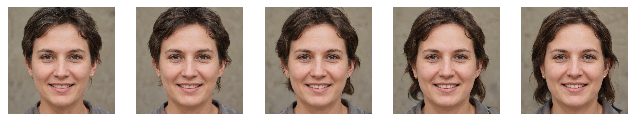

In [618]:
move_and_show(avgzero, gender_coef, np.linspace(-4, 4, 5),coeffstart=1, coeffend=2)

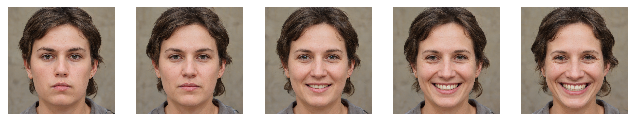

In [418]:
move_and_show(avgzero, joy_coef, [-1, -0.5, 0, 0.5, 1],coeffstart=4, coeffend=5)

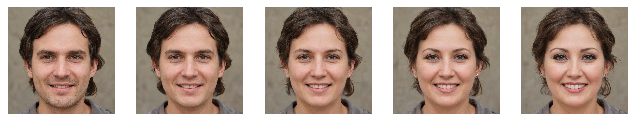

In [429]:
move_and_show(avgzero, gender_coef, [-1, -0.5, 0, 0.5, 1],coeffstart=6, coeffend=7)

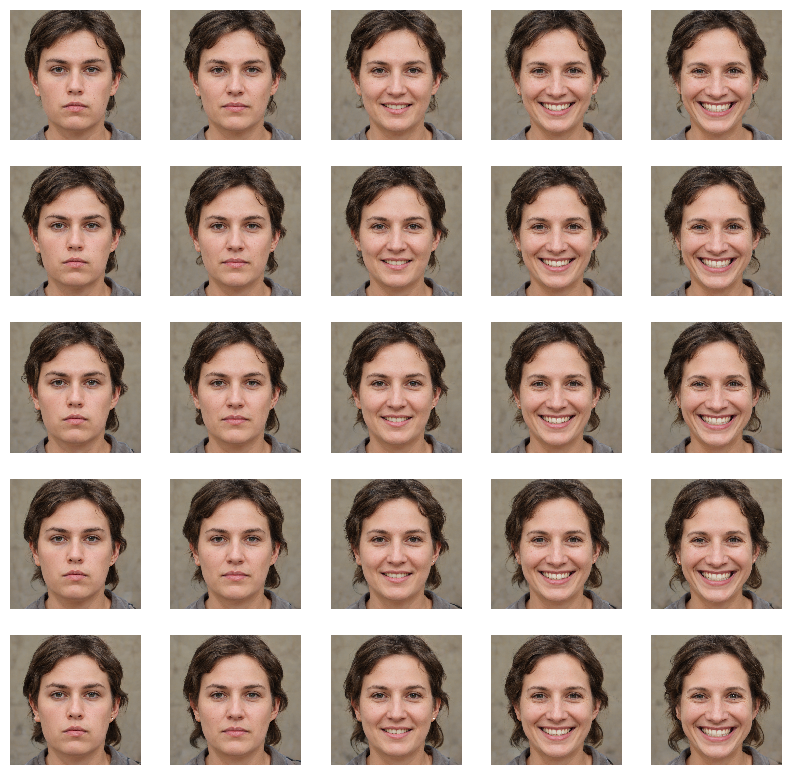

In [614]:
span = [-1, -0.5, 0, 0.5, 1]
move_and_show_2d(avgzero, gender_coef, np.linspace(-1, 1, 5), joy_coef, span, coeffstart1=0, coeffend1=2, coeffstart2=4, coeffend2=5)

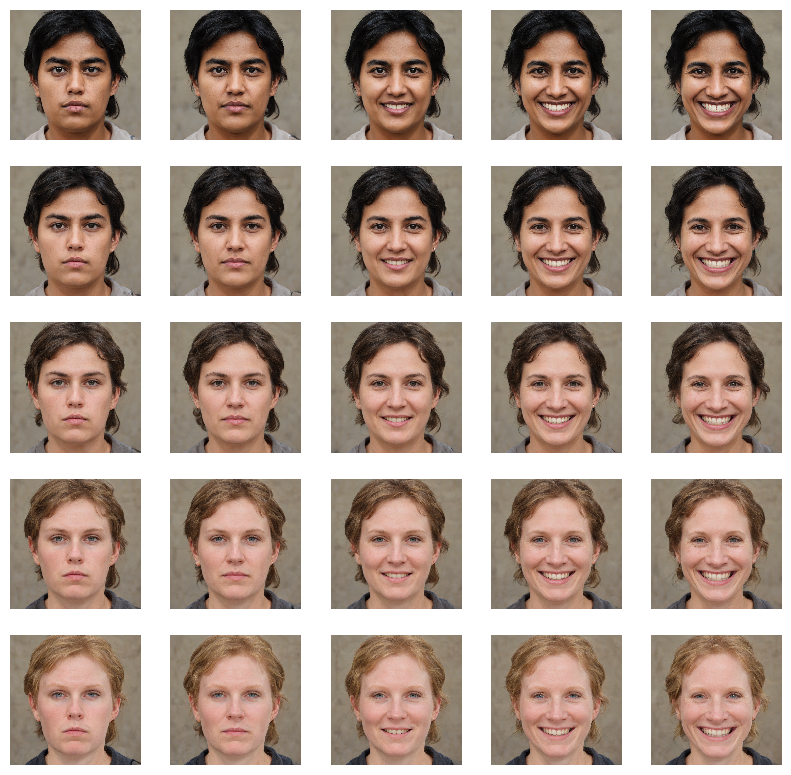

In [441]:
pan = [-1, -0.5, 0, 0.5, 1]
move_and_show_2d(avgzero, white_coef, span, joy_coef, span, coeffstart1=8, coeffend1=9, coeffstart2=4, coeffend2=5)

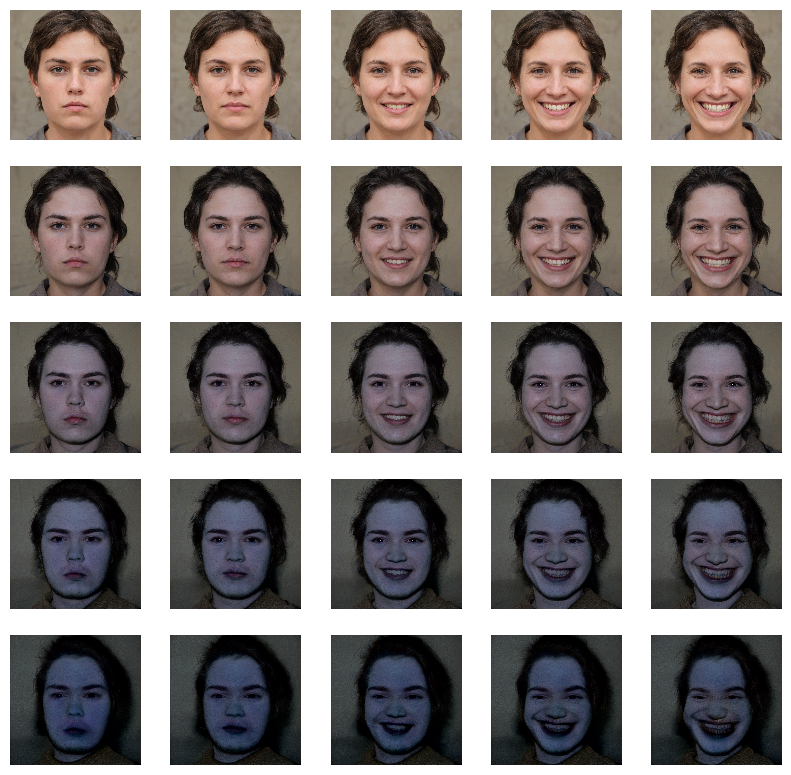

In [478]:
span = [-1, -0.5, 0, 0.5, 1]
move_and_show_2d(avgzero, yaw_lin_coef.reshape((18, 512)), [0, 0.00001, 0.00002, 0.00003, 0.00004], joy_coef, span, coeffstart1=0, coeffend1=19, coeffstart2=4, coeffend2=5)

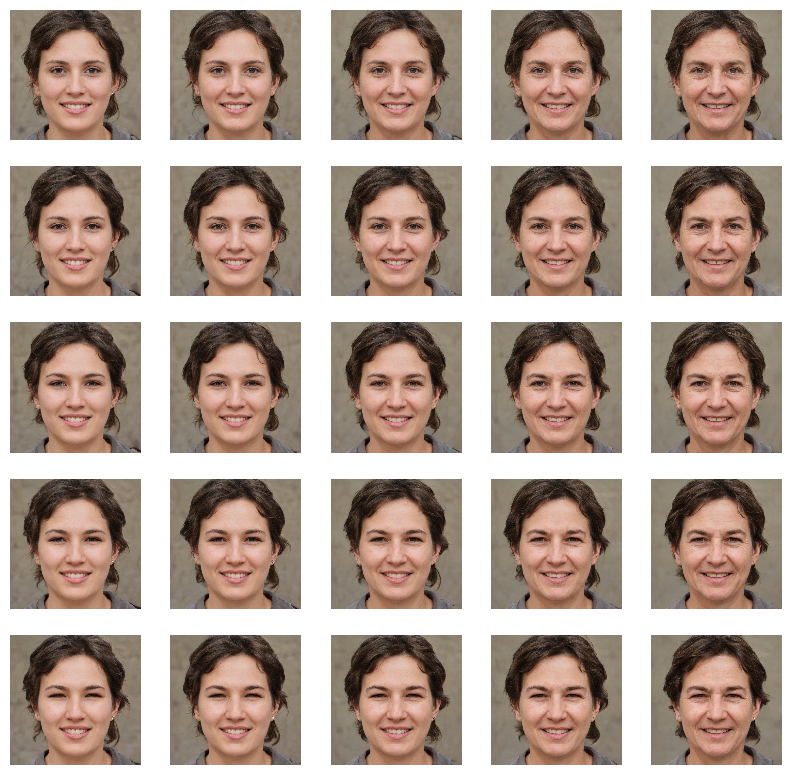

In [556]:
pan = [-1, -0.5, 0, 0.5, 1]
move_and_show_2d(avgzero, blinking_coef, np.linspace(-2, 10, 5), age_coef, np.linspace(-2, 2, 5), coeffstart1=7, coeffend1=8, coeffstart2=6, coeffend2=7)

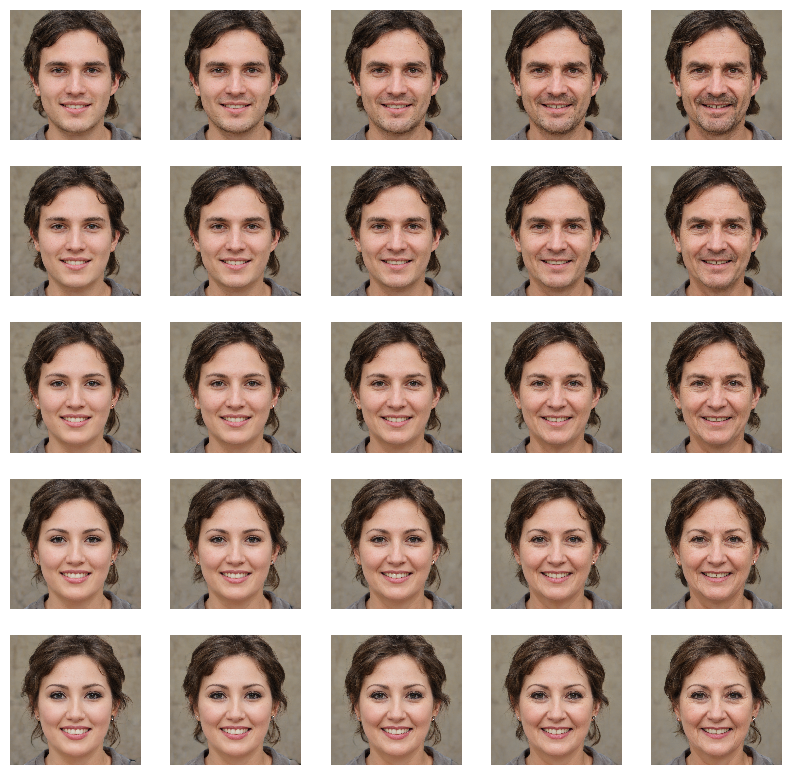

In [611]:
span = [-1, -0.5, 0, 0.5, 1]
move_and_show_2d(avgzero, gender_coef, np.linspace(-1, 1, 5), age_coef, np.linspace(-2, 2, 5), coeffstart1=6, coeffend1=7, coeffstart2=6, coeffend2=7)

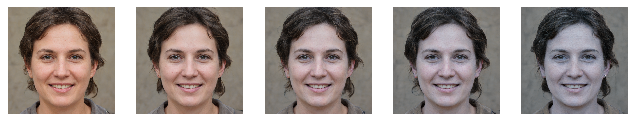

In [605]:
move_and_show(avgzero, yaw_lin_coef.reshape((18, 512)), [0, 0.00001, 0.00002, 0.00003, 0.00004],coeffstart=12,coeffend=14)

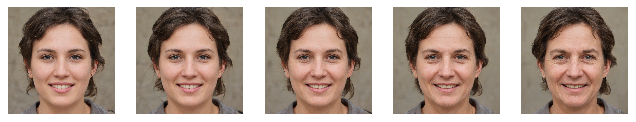

In [530]:
move_and_show(avgzero, age_coef, np.linspace(-2, 2, 5),coeffstart=6,coeffend=7)

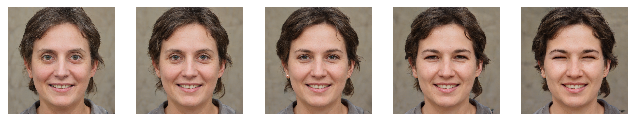

In [621]:
move_and_show(avgzero, blinking_coef, np.linspace(-15, 15, 5),coeffstart=7,coeffend=8)

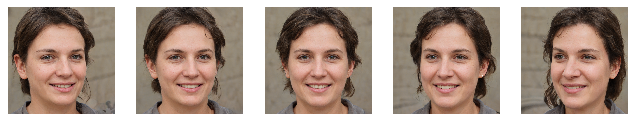

In [587]:
move_and_show(avgzero, yaw_coef, np.linspace(-6, 6, 5),coeffstart=2,coeffend=3)

In [475]:
hmm = np.zeros(shape=(18,512),dtype='float32')
yaw_lin_coef[0:19].shape

(1, 18, 512)

In [620]:
# Start exporting stuff!
zeros = np.zeros(shape=(18,512), dtype='float32')
export_yaw = zeros.copy()
export_yaw[2] = 6 * yaw_coef[2]
np.save('yaw.npy', export_yaw)

export_blinking = zeros.copy()
export_blinking[7] = 15 * blinking_coef[7]
np.save('blinking.npy', export_blinking)

export_age = zeros.copy()
export_age[6] = 2 * age_coef[6]
np.save('age.npy', export_age)


export_joy = zeros.copy()
export_joy[4] = joy_coef[4]
np.save('joy.npy', export_joy)

export_tone = zeros.copy()
export_tone[8] = -white_coef[8]
np.save('tone.npy', export_tone)

export_gender = zeros.copy()
export_gender[6] = gender_coef[6]
np.save('gender.npy', export_gender)

export_hairlength = zeros.copy()
export_hairlength[1] = 4 * gender_coef[1]
np.save('hairlength.npy', export_hairlength)

export_quality = zeros.copy()
export_quality = 0.00001 * yaw_lin_coef.reshape((18, 512))
np.save('quality.npy', export_quality)


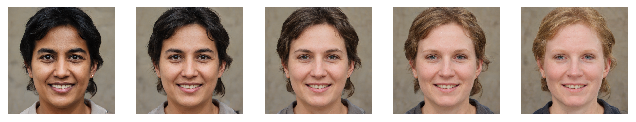

In [383]:
move_and_show(avgzero, white_coef, [-1, -0.5, 0, 0.5, 1],coeffstart=8,coeffend=9)

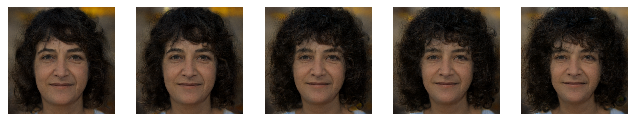

In [312]:
move_and_show(zero, black_coef, [-7, -5, 0, 1, 3],coeffstart=0,coeffend=4)

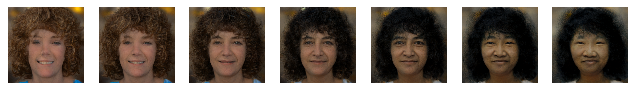

In [296]:
move_and_show(zero, asian_coef, [-13, -10, -5, 0, 5, 10, 13], coeffstart=0,coeffend=18)

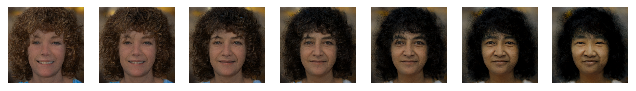

In [256]:
move_and_show(zero, asian_coef, [-13, -10, -5, 0, 5, 10, 13], coeffend=18)

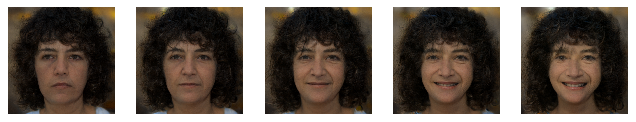

In [316]:
move_and_show(zero, joy_coef, [-8, -4, 0, 4, 8], coeffend=8)

In [302]:
a = [5]
a[None:None]

[5]

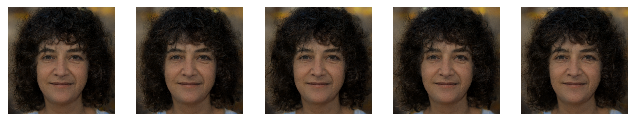

In [240]:
move_and_show(zero, hispanic_minus_gender, [-8, -5, 0, 5, 8], coeffstart=3, coeffcount=3)

In [399]:
def orthogonalize_subtract(vector, base):
  v = vector.reshape((-1))
  b = base.reshape((-1))
  return vector - np.dot(v, b) / np.dot(b, b) * base

white_minus_gender = orthogonalize_subtract(white_coef, gender_coef)
gender_minus_joy = orthogonalize_subtract(gender_coef, joy_coef)

In [229]:
hispanic_minus_gender = orthogonalize_subtract(hispanic_coef, gender_coef)

In [222]:
gen_gif(zero, asian_minus_joy, np.linspace(-13, 13, 50), coeffcount=18)

In [173]:
np.dot(white_coef.reshape((-1)), black_coef[0].reshape((-1)))

-0.5321142631557315

In [175]:
np.dot(white_coef.reshape((-1)), hispanic_coef[0].reshape((-1)))

NameError: name 'hispanic_coef' is not defined

In [17]:
rnd = np.random.RandomState(0)
z1 = np.random.RandomState(0).randn(1, 512).astype('float32')
z2 = np.random.RandomState(1).randn(1, 512).astype('float32')
np.concatenate((z1, z2)).shape

(2, 512)

In [8]:
weights_name = 'ffhq' # face model trained by Nvidia
generator = StyleGan2Generator(weights=weights_name, impl=impl, gpu=gpu)
w_average = np.load('weights/{}_dlatent_avg.npy'.format(weights_name))


Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.
Loaded ffhq generator weights!


In [31]:
for i in range(2048, 4096, 10):
    print(i)
    batch_image(10, generator, i)

2048
2058
2068
2078
2088
2098
2108
2118
2128
2138
2148
2158
2168
2178
2188
2198
2208
2218
2228
2238
2248
2258
2268
2278
2288
2298
2308
2318
2328
2338
2348
2358
2368
2378
2388
2398
2408
2418
2428
2438
2448
2458
2468
2478
2488
2498
2508
2518
2528
2538
2548
2558
2568
2578
2588
2598
2608
2618
2628
2638
2648
2658
2668
2678
2688
2698
2708
2718
2728
2738
2748
2758
2768
2778
2788
2798
2808
2818
2828
2838
2848
2858
2868
2878
2888
2898
2908
2918
2928
2938
2948
2958
2968
2978
2988
2998
3008
3018
3028
3038
3048
3058
3068
3078
3088
3098
3108
3118
3128
3138
3148
3158
3168
3178
3188
3198
3208
3218
3228
3238
3248
3258
3268
3278
3288
3298
3308
3318
3328
3338
3348
3358
3368
3378
3388
3398
3408
3418
3428
3438
3448
3458
3468
3478
3488
3498
3508
3518
3528
3538
3548
3558
3568
3578
3588
3598
3608
3618
3628
3638
3648
3658
3668
3678
3688
3698
3708
3718
3728
3738
3748
3758
3768
3778
3788
3798
3808
3818
3828
3838
3848
3858
3868
3878
3888
3898
3908
3918
3928
3938
3948
3958
3968
3978
3988
3998
4008
4018
4028
4038


In [22]:
rnd = np.random.RandomState(8)
z = rnd.randn(1, 512).astype('float32')
dlatents = generator.mapping_network(z)
out = generator.synthesis_network(dlatents)
img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)

In [31]:
img.numpy()[0]

array([[[ 65,  51, 101],
        [ 36,   8,  73],
        [ 23,   0,  67],
        ...,
        [ 31,  17,  60],
        [ 33,  17,  61],
        [ 46,  28,  68]],

       [[ 30,  17,  89],
        [ 17,   0,  70],
        [ 18,   0,  73],
        ...,
        [ 29,  16,  62],
        [ 37,  20,  62],
        [ 35,  17,  61]],

       [[ 19,   6,  79],
        [ 13,   0,  69],
        [ 17,   0,  79],
        ...,
        [ 26,  14,  69],
        [ 28,  13,  63],
        [ 25,  14,  61]],

       ...,

       [[ 18,   6,  92],
        [ 16,   0,  96],
        [ 13,   0, 100],
        ...,
        [ 15,   3,  22],
        [ 18,   1,  25],
        [ 19,   0,  31]],

       [[ 21,   9,  89],
        [ 11,   0,  82],
        [ 12,   0,  86],
        ...,
        [ 13,   0,  24],
        [ 15,   0,  28],
        [ 21,   0,  38]],

       [[ 37,  16,  93],
        [ 10,   0,  81],
        [ 14,   0,  83],
        ...,
        [ 12,   0,  38],
        [ 18,   0,  48],
        [ 30,   0,  55]]

403 ms ± 8.73 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


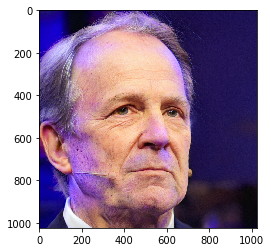

In [23]:
%%timeit
one_image(generator, 8, None, None)